# Kaggle : Locate Heart sound:
<b>https://www.kaggle.com/kinguistics/heartbeat-sounds</b>

## CHALLENGE 1 - Heart Sound Segmentation, is my focus for the Capstone Project

The first challenge is to produce a method that can locate Heart sounds:  HS1(lub) and HS2(dub) sounds within audio data, segmenting the Normal audio files in both datasets. To enable your machine learning method to learn we provide the exact location of S1 and S2 sounds for some of the audio files.



### A  multi class classification problem to differentiate and identify Heart Sounds HS1, HS2 and noise.
We have 3 classes in this case

### The Plan:
The rythm of the heart beat has a very specific pattern and relative spacial orientation. So to locate the heart sounds in an audio file and classify them as Heart Sound 1 / Heart Sound 2 or Space in between the ML model needs to understand relative repetative pattern. The problem is not very different from Image classification where patterns are identified through feature extractions.

The idea of utliizng image classification will be more apparent when we look at Audio file spectogram graph, an example given below.

So the idea is follow the MNIST example of hand written digit classification using tensorflow and Convolution Neural Net  and adapt the code towards audio signal classification (Heart sounds recorded by Digiscope/phone app)

### Data Source Files:  Heart Sound files , with Labels denoting the location of Heart Sound in the audio
Set_A folder from Kaggle link:https://www.kaggle.com/kinguistics/heartbeat-sounds

In [1090]:
import numpy as np
import pandas as pd
import pickle as pk
from IPython.display import Audio
import librosa
import matplotlib.pyplot as plt
%matplotlib inline 

## Input Data analysis: 


### Pre Processing : Audio Signal to Arrays to DataFrames

### Through main.py, settings.py and Extract_HS_Features.py, In earlier stages Audio signals were converted in MFCC arrays for each audio file 

#### As part of preprocessing, the Mels co-effs are extracted from All 21 Labeled Audio files.
The MFCC arrays are extracted as Dictionaries (with File names as keys) & been pickled in labeled_mel_dict.p.  
We alos have got "set_a_timing.csv" file with Heart sound locations with in the audio. The same has been read and er pickled in earlier pre processing 

In [1085]:
fileloc='/Users/spandan.chakraborty/Documents/UML/Capstone/HS/Mycode/Mels/Code/'
filename='labeled_mel_dict.p'
sound_locations=fileloc+'set_a_timing_csv.p'

#### Load Audio - MFCC arrays into Pandas Dataframe:

In [1087]:
### df is a dictionary of All mels co effs (128 mels* duration of the file)
df=pd.read_pickle(fileloc+filename)
### df_sound_loc contains the location of the Heart Sound
df_sound_loc=pd.read_pickle(sound_locations)

#### A sample: how the MFCC convertion looks like: Audio to array
Heart Sound from normal__201108011118.wav file as a sample

In [1089]:
Audio('./normal__201108011118.wav')

#### Here is how the audio plot looks like for the same: represnet normal lub..dub....lub..dub heart sounds
There are two Heart sounds HS1 and HS2 commonly known as lub, dub

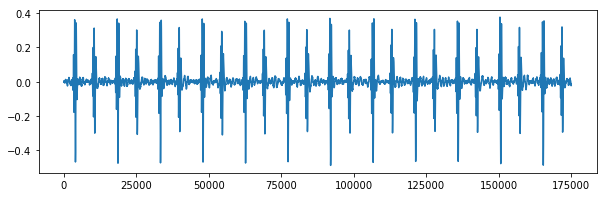

In [1098]:
x, fs = librosa.load('./normal__201108011118.wav')
fig = plt.figure(figsize=(10,3))
plt.plot(x)

### Find below a visual representaion  of the fetaures extracted from Audio signal on Time Frequency map: aka Spectogram
source code reference: https://librosa.github.io/librosa/generated/librosa.feature.melspectrogram.html

It is very clear how audio characteristics follows a spacial pattern over period of time, Which is why the MNIST way of using Convolution Neural Net to classify different Heart sounds is a good fit.

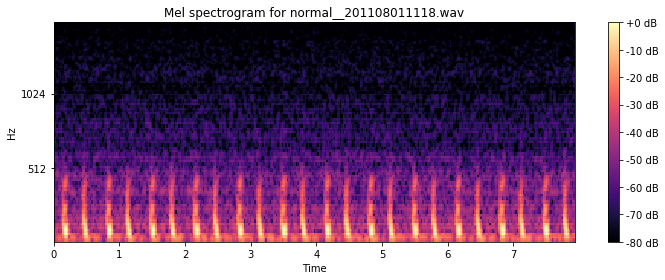

In [1117]:
import librosa.display
S = librosa.feature.melspectrogram(y=x, sr=44100, n_mels=128,fmax=2000)
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(S,ref=np.max),y_axis='mel', fmax=2000,x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram for normal__201108011118.wav')
plt.tight_layout()

### Exploring the Input Data Space:
<ul>
<li>Audio signal info was converted into Array (mels_Co_eff): using Librosa python package, in pre processing step through main, settings and extract_hs_features.py 3 python files. </li>
<li>Each sample audio contains 128 Mel Co effs or features per 0.011 second of audio. The explanation of 0.011 sec sample segment is given below</li> 
<li> The audio is recorded at 44100 samples per second: aka <b>Sampling Rate</b> </li>
<li>In librosa one segment or slice of data under analysis by default contians 512 samples: aka default Hop_length</li>
<li> So each librosa segment contains (512/44100)=0.011 seconds of audio</li>
<li>Each segment ( 0.011 s duration of audio) is represented by 128  co effs</li> 
<li> So an audio file such as "normal__201108011118.wav" which is approx. 8 seconds long has (44100*8/512)= approx. 684 segements</li>
</ul>
### So for an example the audio signal info recorded in   'normal__201108011118.wav' can be represented by an array of size 128*684 
####  For each audio file we will extract 128 mels co eff for per 0.011 secs of audio sample. Based on the audio file duration we will get respective array 128*<no# derived from audio file duration>

In [1113]:
### Example of a dictionary 
print(df['normal__201108011118'].shape)
df['normal__201108011118']

(128, 684)


array([[  8.04295694e-03,   8.93476285e-02,   4.81661272e-01, ...,
          1.65827122e+00,   1.63090038e+00,   2.36399915e+00],
       [  1.56986214e-02,   1.74392900e-01,   9.40129107e-01, ...,
          3.23669169e+00,   3.18326802e+00,   4.61416465e+00],
       [  2.43042414e-01,   3.93015880e-01,   6.82248374e-01, ...,
          6.73354401e-01,   1.07922115e+00,   3.23077510e+00],
       ..., 
       [  1.87514210e-06,   5.44098180e-07,   1.67955814e-06, ...,
          1.61014473e-07,   2.96333669e-06,   5.41442064e-05],
       [  1.90644479e-07,   1.50682207e-06,   2.07056151e-06, ...,
          5.78843901e-07,   4.55531865e-06,   6.18284918e-05],
       [  4.18645852e-07,   2.09581515e-06,   4.93758600e-06, ...,
          2.27469929e-06,   2.57632735e-06,   3.87966964e-05]])

### Applying Lables on raw data : Location of HS1 & HS2 
As per set_a_timing_csv

In [1118]:
df_sound_loc.fname=df_sound_loc.fname.str.replace('set_a/','')
df_sound_loc.fname=df_sound_loc.fname.str.replace('.wav','')
df_sound_loc[df_sound_loc.fname.str.contains('normal__201108011118')].head(2)

,fname,cycle,sound,location,TimeInSec,segment,HS_Start,HS_End,n_start,n_end
366,normal__201108011118,1,S1,7591,0.172132,14,8,20,21,33.0
367,normal__201108011118,1,S2,20496,0.464762,40,34,46,47,65.0


### Tag info per  location of Heart sounds , as given in "set_a_timing.csv": Segments
The audio was recorded @44100 audio samples per second : also called Sample Rate (SR)
The Window width for Librosa is 512 samples per segment
Converting the labeled location into Segment. 
Each segment represents roughly 0.011 seconds long audio samples

In [1119]:

df_sound_loc['segment']=(df_sound_loc['location']/512).astype(int)
df_sound_loc[df_sound_loc.fname.str.contains('normal__201108011118')].head(2)

,fname,cycle,sound,location,TimeInSec,segment,HS_Start,HS_End,n_start,n_end
366,normal__201108011118,1,S1,7591,0.172132,14,8,20,21,33.0
367,normal__201108011118,1,S2,20496,0.464762,40,34,46,47,65.0


### Since HS lasts approx. 0.11- 0.14  secs & 1 sec of wav file contains 87 segments (for 44100 Sample Rate and 512 Hop length (window size  512 samples)).. it turns out the HS will be of 0.14*87  ~= 12 segment long

In [1120]:
df_sound_loc['HS_Start']=(df_sound_loc['segment']-6).astype(int)

In [1121]:
df_sound_loc['HS_End']=(df_sound_loc['segment']+6).astype(int)

In [1122]:
df_sound_loc[df_sound_loc.fname.str.contains('normal__201108011118')].head(2)

,fname,cycle,sound,location,TimeInSec,segment,HS_Start,HS_End,n_start,n_end
366,normal__201108011118,1,S1,7591,0.172132,14,8,20,21,33.0
367,normal__201108011118,1,S2,20496,0.464762,40,34,46,47,65.0


### More Data processing:
#### Extract the noise window between Heart Sounds. Tagging the sound found between two consequtive Heart sounds as Noise.

In [1137]:
df_sound_loc['n_start']=df_sound_loc.groupby('fname')['HS_End'].apply(lambda x: x+1)

In [1138]:
# shift(-1) provides the next row reference
df_sound_loc['n_end']=df_sound_loc.groupby('fname')['HS_Start'].shift(-1).apply(lambda x:x-1)

In [1139]:
df_noise=pd.DataFrame()
df_noise=df_sound_loc.copy()
# exclude the lines where n_start-n_end <12 segments
df_noise[(df_noise['n_end']-df_noise['n_start'])<12].index

Int64Index([  0,   2,   4,   6,   8,  10,  12,  14,  16,  18,
            ...
            280, 282, 288, 292, 370, 372, 376, 380, 384, 388],
           dtype='int64', length=111)

In [1140]:
df_noise.drop(df_noise[(df_noise['n_end']-df_noise['n_start'])<12].index, inplace=True)
df_noise.dropna(how='any', inplace=True)  ## Any row Has nan value will be dropped

In [1141]:
df_noise.n_end=df_noise.n_end.astype(int)

#### We are taking 12 sgements to tag each noise space to maintain uniformity with 12 segmenst we took for each Heart Sounds

In [1142]:
df_noise['nn_end']=df_noise.n_start+12
df_noise.sound='n'
df_noise.head(2)

,fname,cycle,sound,location,TimeInSec,segment,HS_Start,HS_End,n_start,n_end,nn_end
1,normal__201102081321,1,n,20759,0.470726,40,34,46,47,61,59
3,normal__201102081321,2,n,47244,1.071293,92,86,98,99,116,111


In [1143]:
df_hs=pd.DataFrame()
df_hs=df_sound_loc.copy()
df_hs.drop(['cycle','location','TimeInSec','segment','n_start','n_end'], axis=1, inplace=True)
df_hs.rename(columns={'HS_Start': 'start','HS_End':'end'}, inplace=True)
df_hs.head(2)

,fname,sound,start,end
0,normal__201102081321,S1,13,25
1,normal__201102081321,S2,34,46


In [1144]:
df_noise.drop(['cycle','location','TimeInSec','segment','HS_Start','HS_End','n_end'], axis=1, inplace=True)
df_noise.rename(columns={'n_start':'start','nn_end':'end'}, inplace=True)
df_noise.head(2)

,fname,sound,start,end
1,normal__201102081321,n,47,59
3,normal__201102081321,n,99,111


### Bringing together the Heart Sound and Noise Labeled Segments 

In [1151]:
df_s=pd.concat([df_hs,df_noise], axis=0)
print(len(df_s))
df_s.groupby('sound').size()

648


sound
S1    195
S2    195
n     258
dtype: int64

### Get the Mels value from Dictionary using File names as key through map 
#### The idea is to Slice the 128 mels of 0.14 secs of Slices (Almost 12 segements around the HS labled Locations )

In [1152]:
df_s['mels']=df_sound_loc['fname'].map(df)

In [1153]:
df_s[df_s.fname.str.contains('normal__201108011118')].head(2)

,fname,sound,start,end,mels
366,normal__201108011118,S1,8,20,"[[0.00804295694391, 0.089347628485, 0.48166127..."
367,normal__201108011118,S2,34,46,"[[0.00804295694391, 0.089347628485, 0.48166127..."


### Following code used list Slicing fetching the Heart Sound location specific Mels
#### Now we have a dataset ready for the model with HS1 , HS2 , Noise labeled data with their Features, refer to mels_seg column 

In [1154]:
df_s['mels_seg'] = df_s.apply(lambda x: x['mels'][:, x['start']:x['end']].tolist(),axis=1)

In [1155]:
df_s.head(2)

,fname,sound,start,end,mels,mels_seg
0,normal__201102081321,S1,13,25,"[[0.0752865622903, 0.00439239454838, 0.0182232...","[[0.0171469795289, 0.0173154008662, 0.39569554..."
1,normal__201102081321,S2,34,46,"[[0.0752865622903, 0.00439239454838, 0.0182232...","[[0.0471267533454, 0.0061760868171, 0.00564760..."


#### Converting the mels_seg from List to array

In [1156]:
np.array(df_s.ix[0, 'mels_seg']).shape  ## np.array converts the list to Array 

(128, 12)

#### Classifying the Sounds into One Hot Encoded labels

In [1157]:
df_s.drop('mels', inplace=True)
#df_s.head(2)
S1=np.array([1.0,0.0,0.0])
S2=np.array([0.0,1.0,0.0])
n=np.array([0.0,0.0,1.0])
sound_class={'S1':S1,'S2':S2,'n':n}
df_s['class']=df_s['sound'].map(sound_class)
#df_s['mels_flatten']=df_s['mels_seg'].apply(lambda x: np.asarray(x).flatten())
df_s['mels_flatten']=df_s['mels_seg'].apply(np.ravel)
df_s.head(2)

,fname,sound,start,end,mels,mels_seg,class,mels_flatten
0,normal__201102081321,S1,13,25,"[[0.0752865622903, 0.00439239454838, 0.0182232...","[[0.0171469795289, 0.0173154008662, 0.39569554...","[1.0, 0.0, 0.0]","[0.0171469795289, 0.0173154008662, 0.395695541..."
1,normal__201102081321,S2,34,46,"[[0.0752865622903, 0.00439239454838, 0.0182232...","[[0.0471267533454, 0.0061760868171, 0.00564760...","[0.0, 1.0, 0.0]","[0.0471267533454, 0.0061760868171, 0.005647608..."


### Data Cleansing before Training
#### Check if all the elements in the Dataset is correct  & have same size , has 128 features/segment and have 12 segments
128* 12  =1536

In [1159]:
df_s['mels_flatten'].apply(len).unique()

array([1536,    0])

##### It indicates there are 0 length Data elements in mels_flatten: find and delete the non confirming data:

In [1163]:
df_s[df_s['mels_flatten'].apply(len)==0].index

Int64Index([136, 294], dtype='int64')

#### Data with blank mels feature

In [1164]:
df_s.iloc[[136,294]]

,fname,sound,start,end,mels,mels_seg,class,mels_flatten
136,normal__201105011626,S1,-1,11,"[[0.147678276527, 0.040960011283, 0.0059928980...","[[], [], [], [], [], [], [], [], [], [], [], [...","[1.0, 0.0, 0.0]",[]
294,normal__201106221450,S1,-1,11,"[[0.000655332564528, 0.0046009260886, 0.067146...","[[], [], [], [], [], [], [], [], [], [], [], [...","[1.0, 0.0, 0.0]",[]


##### drop the rogue elements & then check again:

In [1166]:
df_s.drop(df_s.index[[136,294]], inplace= True)

In [1173]:
print(df_s['mels_flatten'].apply(len).unique())
print(df_s['class'].apply(len).unique())

[1536]
[3]


#### We have 642 labeled audio segments , we have almost equal representation of all 3 sound classes :
HS1, HS2 and Noise

In [1176]:
print(len(df_s))
df_s.groupby('sound').size()

642


sound
S1    192
S2    194
n     256
dtype: int64

In [1181]:
df_num={'S1':1,'S2':2,'n':3}
df_s['sound_num']=df_s['sound'].map(df_num)
df_s.groupby('sound_num').size()

sound_num
1    192
2    194
3    256
dtype: int64

### Establish Baseline for a MultiClass Classification : Zero Rule Classification
#### The largest no# of occurance is for Noise. So if our model always predict the majority then we are looking at 60% error rate.

In [1182]:
print ('Error Rate if we always predict Majority (which is noise):',(192+194)/642.)

Error Rate if we always predict Majority (which is noise): 0.601246105919


### Train Test Split : Prepare for Model Training
#### Input Data Set:

In [1185]:
from sklearn.model_selection import train_test_split
X_All=df_s.ix[:,['mels_flatten']]
y_All=df_s.ix[:,['class']] 
print(X_All.size, y_All.size)

642 642


#### Spiltting 85% Train data , validation data and 15% test Data 
#### Further splitting into Train 
##### To ensure all the class are well represented in Train , Validation and test split,  Each class data has been split individually and then has been combined together to form the final Train - Val -Test split 

In [1195]:
X_All_s1=X_All[df_s['sound']=='S1']['mels_flatten']
X_All_s2=X_All[df_s['sound']=='S2']['mels_flatten']
X_All_n=X_All[df_s['sound']=='n']['mels_flatten']
print('no# of S1:',len(X_All_s1),' S2:',len(X_All_s2),' n:',len(X_All_n))

y_All_s1=y_All[df_s['sound']=='S1']['class']
y_All_s2=y_All[df_s['sound']=='S2']['class']
y_All_n=y_All[df_s['sound']=='n']['class']
print('no# of S1:',len(y_All_s1),' S2:',len(y_All_s2),' n:',len(y_All_n))

no# of S1: 192  S2: 194  n: 256
no# of S1: 192  S2: 194  n: 256


#### S1 train _Val_Test Split

In [1215]:
X_trv_S1_df, X_test_S1_df, y_trv_S1_df, y_test_S1_df = train_test_split(X_All_s1, y_All_s1, test_size=0.15, random_state=42)
print(len(X_trv_S1_df),len(X_test_S1_df), len(y_trv_S1_df), len(y_test_S1_df))

163 29 163 29


##### Further splitting Train data (90%) and Validation Data (10%)

In [1202]:
X_tr_S1_df, X_val_S1_df, y_tr_S1_df, y_val_S1_df = train_test_split(X_trv_S1_df, y_trv_S1_df, test_size=0.1, random_state=42)
print(len(X_tr_S1_df),len(X_val_S1_df), len(y_tr_S1_df), len(y_val_S1_df))

146 17 146 17


In [1204]:
X_tr_S1_df.head(1)

306    [0.00246430780796, 0.0133255041211, 0.00048672...
Name: mels_flatten, dtype: object

#### S2 train _Val_Test Split

In [1216]:
X_trv_S2_df, X_test_S2_df, y_trv_S2_df, y_test_S2_df = train_test_split(X_All_s2, y_All_s2, test_size=0.15, random_state=42)
print(len(X_trv_S2_df),len(X_test_S2_df), len(y_trv_S2_df), len(y_test_S2_df))

164 30 164 30


##### Further splitting Train data (90%) and Validation Data (10%)

In [1207]:
X_tr_S2_df, X_val_S2_df, y_tr_S2_df, y_val_S2_df = train_test_split(X_trv_S2_df, y_trv_S2_df, test_size=0.1, random_state=42)
print(len(X_tr_S2_df),len(X_val_S2_df), len(y_tr_S2_df), len(y_val_S2_df))

147 17 147 17


#### Noise train _Val_Test Split

In [1217]:
X_trv_n_df, X_test_n_df, y_trv_n_df, y_test_n_df = train_test_split(X_All_n, y_All_n, test_size=0.15, random_state=42)
print(len(X_trv_n_df),len(X_test_n_df), len(y_trv_n_df), len(y_test_n_df))

217 39 217 39


##### Further splitting Train data (90%) and Validation Data (10%)

In [1209]:
X_tr_n_df, X_val_n_df, y_tr_n_df, y_val_n_df = train_test_split(X_trv_n_df, y_trv_n_df, test_size=0.1, random_state=42)
print(len(X_tr_n_df),len(X_val_n_df), len(y_tr_n_df), len(y_val_n_df))

195 22 195 22


#### Stitch back Train Validation Test Split Data

In [1222]:
X_tr_df=pd.concat([X_tr_S1_df,X_tr_S2_df,X_tr_n_df], axis=0)
X_val_df=pd.concat([X_val_S1_df,X_val_S2_df,X_val_n_df], axis=0)
X_test_df=pd.concat([X_test_S1_df,X_test_S2_df,X_test_n_df], axis=0)

In [1212]:
y_tr_df=pd.concat([y_tr_S1_df,y_tr_S2_df,y_tr_n_df], axis=0)
y_val_df=pd.concat([y_val_S1_df,y_val_S2_df,y_val_n_df], axis=0)
y_test_df=pd.concat([y_test_S1_df,y_test_S2_df,y_test_n_df], axis=0)

### Dataframe to Ndarray for Tensorflow Conv. net input

In [1243]:
## This one is used to pass a flat array to t
X_train=np.vstack(X_tr_df.values) 
X_val=np.vstack(X_val_df.values)
X_test=np.vstack(X_test_df.values)

y_train=np.vstack(y_tr_df.values)
y_val=np.vstack(y_val_df.values)
y_test=np.vstack(y_test_df.values)

print('Train:',X_train.shape, y_train.shape)
print('Val:',X_val.shape, y_val.shape)
print('Test:',X_test.shape, y_test.shape)

Train: (488, 1536) (488, 3)
Val: (56, 1536) (56, 3)
Test: (98, 1536) (98, 3)


# Build a Multilayer Convolutional Network


### Build the Model with Tesnorflow

In [1378]:
import tensorflow as tf
from tqdm import tqdm

LOGDIR = '/Users/spandan.chakraborty/Documents/UML/Capstone/HS/Mycode/Mels/Code/tensorboard/log'
MODELDIR = '/Users/spandan.chakraborty/Documents/UML/Capstone/HS/Mycode/Mels/Code/tensorboard'
#sess = tf.InteractiveSession()

#### Placeholders: We start building the computation graph by creating nodes for the input images and target output classes.

In [1328]:
x = tf.placeholder(tf.float32, shape=[None, 1536], name='x_variable')
y_ = tf.placeholder(tf.float32, shape=[None, 3],name='y_variable')

Here x and y_ aren't specific values. Rather, they are each a placeholder -- a value that we'll input when we ask TensorFlow to run a computation.

The input images x will consist of a 2d tensor of floating point numbers. Here we assign it a shape of [None, 1536], where 1536 is the dimensionality of a single flattened 128 mels by 12 segments Audio attributes, and None indicates that the first dimension, corresponding to the batch size, can be of any size. The target output classes y_ will also consist of a 2d tensor, where each row is a one-hot 3-dimensional vector indicating which digit class (1 to 3 corresponding to S1, S2 and Noise) the corresponding Heart Sound the audio section belongs to.

The shape argument to placeholder is optional, but it allows TensorFlow to automatically catch bugs stemming from inconsistent tensor shapes.

#### To apply the layer, we first reshape x to a 4d tensor, 
with the second and third dimensions corresponding to Audio Mels Co efficients and Duration converted into Segements (12 segments corresponds to 0.14 sec of audio in .wav format, roughly equals to a heart Sound duration), and the final dimension for image processing corresponds to the number of color channels.. since I am using MNIST source code, but in my case I just kept it as 1.

In [1297]:
# x_audio = tf.reshape(x, [-1, 128, 12, 1])

#### Dropout

To reduce overfitting, we will apply dropout before the readout layer. We create a placeholder for the probability that a neuron's output is kept during dropout. This allows us to turn dropout on during training, and turn it off during testing. TensorFlow's tf.nn.dropout op automatically handles scaling neuron outputs in addition to masking them, so dropout just works without any additional scaling.1

In [1302]:
# keep_prob = tf.placeholder(tf.float32)
# h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob, name ='Dropout')

In [1067]:
# sess1.close()

# Try out more Modular Method:
https://github.com/dandelionmane/tf-dev-summit-tensorboard-tutorial/blob/master/mnist.py
    

#### Define Conv. Layer with maxpool:

In [1329]:
def conv_layer(input, size_in, size_out, name="conv"):
    with tf.name_scope(name):
        w = tf.Variable(tf.truncated_normal([5, 5, size_in, size_out], stddev=0.1), name="W")
        b = tf.Variable(tf.constant(0.1, shape=[size_out]), name="B")
        conv = tf.nn.conv2d(input, w, strides=[1, 1, 1, 1], padding="SAME")
        act = tf.nn.relu(conv + b)
        tf.summary.histogram("weights", w)
        tf.summary.histogram("biases", b)
        tf.summary.histogram("activations", act)
        return tf.nn.max_pool(act, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")

#### Define Fully Connected layer:

In [1330]:
def fc_layer(input, size_in, size_out, name="fc"):
    with tf.name_scope(name):
        w = tf.Variable(tf.truncated_normal([size_in, size_out], stddev=0.1), name="W")
        b = tf.Variable(tf.constant(0.1, shape=[size_out]), name="B")
        act = tf.matmul(input, w) + b
        tf.summary.histogram("weights", w)
        tf.summary.histogram("biases", b)
        tf.summary.histogram("activations", act)
        return act

In [1437]:
def mnist_model(learning_rate, use_two_fc, use_two_conv, hparam, epoch=101):

    tf.reset_default_graph()
    sess = tf.Session()

    # Setup placeholders, and reshape the data
    x = tf.placeholder(tf.float32, shape=[None, 1536], name="x")
    x_audio = tf.reshape(x, [-1, 128, 12, 1])
    y = tf.placeholder(tf.float32, shape=[None, 3], name="labels")

    if use_two_conv:
        conv1 = conv_layer(x_audio, 1, 32, "conv1")
        conv_out = conv_layer(conv1, 32, 64, "conv2")
    else:
        conv1 = conv_layer(x_audio, 1, 64, "conv")
        conv_out = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")

    flattened = tf.reshape(conv_out, [-1, 32 * 3 * 64])


    if use_two_fc:
        fc1 = fc_layer(flattened, 32 * 3 * 64, 1024, "fc1")
        relu = tf.nn.relu(fc1)
        embedding_input = relu
        tf.summary.histogram("fc1/relu", relu)
        embedding_size = 1024
        logits = fc_layer(fc1, 1024, 3, "fc2")
    else:
        embedding_input = flattened
        embedding_size = 32*3*64
        logits = fc_layer(flattened, 32*3*64, 3, "fc")

    with tf.name_scope("xent"):
        xent = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(
                logits=logits, labels=y), name="xent")
        tf.summary.scalar("xent", xent)

    with tf.name_scope("train"):
        train_step = tf.train.AdamOptimizer(learning_rate).minimize(xent)

    with tf.name_scope("accuracy"):
        correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        tf.summary.scalar("accuracy", accuracy)

    summ = tf.summary.merge_all()


#     embedding = tf.Variable(tf.zeros([1024, embedding_size]), name="test_embedding")
#     assignment = embedding.assign(embedding_input)


    sess.run(tf.global_variables_initializer())
    writer = tf.summary.FileWriter(LOGDIR + hparam)
    writer.add_graph(sess.graph)


    #for i in progress(range(epoch)):
    for i in range(epoch):
        #A All Data to be processed in 1 batch
        if i % 100 == 0:
            [train_accuracy, s] = sess.run([accuracy, summ], feed_dict={x: X_train, y: y_train})
            writer.add_summary(s, i)
            print('training accuracy', train_accuracy, ' @ run #', i)

        sess.run(train_step, feed_dict={x: X_train, y: y_train})
    
    
    ### Save the model in .meta file
    saver = tf.train.Saver()   
    saver.save(sess,MODELDIR+hparam)   
    ## Accuracy on Validtaion Set 
    val_accuracy = sess.run(accuracy,feed_dict={x: X_val, y: y_val})
    print('Accuracy on Validation set', val_accuracy)
    y_val_pred=sess.run(tf.argmax(logits,1), feed_dict={x: X_val})
    
    
    test_accuracy = sess.run(accuracy,feed_dict={x: X_test, y: y_test})
    print('Accuracy on Test set', val_accuracy)
    y_test_pred=sess.run(tf.argmax(logits,1), feed_dict={x: X_test})
    return y_test_pred
    

In [1341]:
def make_hparam_string(learning_rate, use_two_fc, use_two_conv):
    conv_param = "conv=2" if use_two_conv else "conv=1"
    fc_param = "fc=2" if use_two_fc else "fc=1"
    return "lr_%.0E,%s,%s" % (learning_rate, conv_param, fc_param)

In [1356]:
def main():
    # You can try adding some more learning rates
    for learning_rate in [1E-2,1E-3, 1E-4]:
        # Include "False" as a value to try different model architectures
        for use_two_fc in [True]:
            for use_two_conv in [False, True]:
                # Construct a hyperparameter string for each one (example: "lr_1E-3,fc=2,conv=2")
                hparam = make_hparam_string(learning_rate, use_two_fc, use_two_conv)
                print('Starting run for %s' % hparam)
                # Actually run with the new settings
                y_val_pred_main=mnist_model(learning_rate, use_two_fc, use_two_conv, hparam, epoch=101)
    
    print('Done training!')
    return y_val_pred_main

### Run 1 with Epoch =101 to get an idea which Hyper Parameter fares well on Training and Validation Set

In [1349]:
y_val_prd_result=main()

Starting run for lr_1E-02,conv=1,fc=2
training accuracy 0.516393  @ run # 0
training accuracy 0.618852  @ run # 50
training accuracy 0.606557  @ run # 100
Accuracy on Validation set 0.571429
Starting run for lr_1E-02,conv=2,fc=2
training accuracy 0.32582  @ run # 0
training accuracy 0.57377  @ run # 50
training accuracy 0.682377  @ run # 100
Accuracy on Validation set 0.642857
Starting run for lr_1E-03,conv=1,fc=2
training accuracy 0.42623  @ run # 0
training accuracy 0.752049  @ run # 50
training accuracy 0.840164  @ run # 100
Accuracy on Validation set 0.732143
Starting run for lr_1E-03,conv=2,fc=2
training accuracy 0.241803  @ run # 0
training accuracy 0.778689  @ run # 50
training accuracy 0.891393  @ run # 100
Accuracy on Validation set 0.696429
Starting run for lr_1E-04,conv=1,fc=2
training accuracy 0.120902  @ run # 0
training accuracy 0.70082  @ run # 50
training accuracy 0.77459  @ run # 100
Accuracy on Validation set 0.732143
Starting run for lr_1E-04,conv=2,fc=2
training acc

### Based on the above short run 
#### Will Try to Experiment with More Epochs with following :
<ol>
<li><b>lr_1E-03,conv=1,fc=2:</b> training accuracy 0.682377  @ run # 100
Accuracy on Validation set 0.642857</li>
<li><b>lr_1E-03,conv=2,fc=2:</b> training accuracy 0.891393  @ run # 100
Accuracy on Validation set 0.696429</li>

</ol>



### 1st Trial  : lr_1E-03,conv=1,fc=2

In [1361]:
def main():
    # You can try adding some more learning rates
    learning_rate=1E-03
    use_two_fc=True
    use_two_conv=False

    hparam = make_hparam_string(learning_rate, use_two_fc, use_two_conv)
    # Actually run with the new settings
    y_val_pred_main=mnist_model(learning_rate, use_two_fc, use_two_conv, hparam, epoch=1001)
    
    print('Done training!')
    return y_val_pred_main

In [1380]:

y_val_prd_result_1=main()

training accuracy 0.29918  @ run # 0
training accuracy 0.852459  @ run # 100
training accuracy 0.920082  @ run # 200
training accuracy 0.946721  @ run # 300
training accuracy 0.95082  @ run # 400
training accuracy 0.952869  @ run # 500
training accuracy 0.954918  @ run # 600
training accuracy 0.956967  @ run # 700
training accuracy 0.959016  @ run # 800
training accuracy 0.963115  @ run # 900
training accuracy 0.965164  @ run # 1000
Accuracy on Validation set 0.821429
Done training!


### 2nd Trial  : lr_1E-03,conv=2,fc=2

In [1381]:
def main():
    # You can try adding some more learning rates
    learning_rate=1E-03
    use_two_fc=True
    use_two_conv=True

    hparam = make_hparam_string(learning_rate, use_two_fc, use_two_conv)
    # Actually run with the new settings
    y_val_pred_main=mnist_model(learning_rate, use_two_fc, use_two_conv, hparam, epoch=1001)
    
    print('Done training!')
    return y_val_pred_main

In [1382]:
y_val_prd_result_2=main()

training accuracy 0.260246  @ run # 0
training accuracy 0.885246  @ run # 100
training accuracy 0.944672  @ run # 200
training accuracy 0.956967  @ run # 300
training accuracy 0.961066  @ run # 400
training accuracy 0.971311  @ run # 500
training accuracy 0.97541  @ run # 600
training accuracy 0.981557  @ run # 700
training accuracy 0.983607  @ run # 800
training accuracy 0.985656  @ run # 900
training accuracy 0.985656  @ run # 1000
Accuracy on Validation set 0.785714
Done training!


### Run Model on Test Data: lr_1E-03,conv=1,fc=2
#### Selecting the Model file related to 
to run on Test Data 

In [1440]:
def main():
    # You can try adding some more learning rates
    learning_rate=1E-03
    use_two_fc=True
    use_two_conv=False

    hparam = make_hparam_string(learning_rate, use_two_fc, use_two_conv)
    # Actually run with the new settings
    y_test_pred_main=mnist_model(learning_rate, use_two_fc, use_two_conv, hparam, epoch=1001)
    
    print('Done training!')
    return y_test_pred_main

In [1441]:
y_test_prd_result=main()

training accuracy 0.280738  @ run # 0
training accuracy 0.864754  @ run # 100
training accuracy 0.915984  @ run # 200
training accuracy 0.944672  @ run # 300
training accuracy 0.954918  @ run # 400
training accuracy 0.959016  @ run # 500
training accuracy 0.959016  @ run # 600
training accuracy 0.959016  @ run # 700
training accuracy 0.961066  @ run # 800
training accuracy 0.961066  @ run # 900
training accuracy 0.963115  @ run # 1000
Accuracy on Validation set 0.785714
Accuracy on Test set 0.785714
Done training!


### Metrics Evaluation: How the model is doing 
#### Will use SkLearn  Confusion Matrix  & Classification report to measure precision, recall, f1 score for our multiclass model

In [1384]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import itertools
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

In [1405]:
classes=['S1','S2','N']
print(classes)
#print(y_pred[0:20])
t1,t2=np.unique(y_val_prd_result_2, return_counts=True)
print(t1, t2)

['S1', 'S2', 'N']
[0 1 2] [13 19 24]


In [1442]:
y_val_arg_max=np.argmax(y_val, axis=1)

### Confuison Matrix for  1st Trial  : lr_1E-03,conv=1,fc=2  on Validation Data Set

Confusion matrix, without normalization


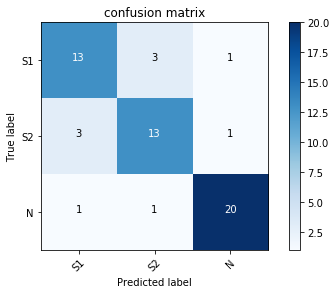

In [1447]:
cnf_matrix = confusion_matrix(y_val_arg_max, y_val_prd_result_1)
plot_confusion_matrix(cnf_matrix, classes=classes, normalize=False,
                      title='confusion matrix')

In [1451]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_val_arg_max, y_val_prd_result_1, average=None)

(array([ 0.76470588,  0.76470588,  0.90909091]),
 array([ 0.76470588,  0.76470588,  0.90909091]),
 array([ 0.76470588,  0.76470588,  0.90909091]),
 array([17, 17, 22]))

### Confuison Matrix for  2nd Trial  : lr_1E-03,conv=2,fc=2  on Validation Data Set

Confusion matrix, without normalization


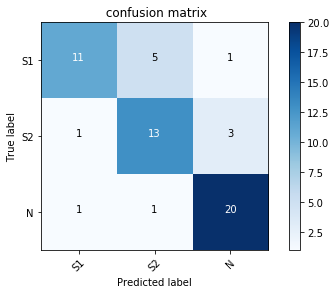

In [1453]:
cnf_matrix = confusion_matrix(y_val_arg_max, y_val_prd_result_2)
plot_confusion_matrix(cnf_matrix, classes=classes, normalize=False,
                      title=' confusion matrix')

In [1454]:
precision_recall_fscore_support(y_val_arg_max, y_val_prd_result_2, average=None)

(array([ 0.84615385,  0.68421053,  0.83333333]),
 array([ 0.64705882,  0.76470588,  0.90909091]),
 array([ 0.73333333,  0.72222222,  0.86956522]),
 array([17, 17, 22]))

In [1445]:
#df_s.iloc[y_val_df[(y_val_arg_max==y_val_prd_result_1)].index].sort_values(['fname', 'start']).head(10)

### Confusion Matrix and f1-Score on Test Data

In [1449]:
y_test_argmax=np.argmax(y_test, axis=1)

Confusion matrix, without normalization


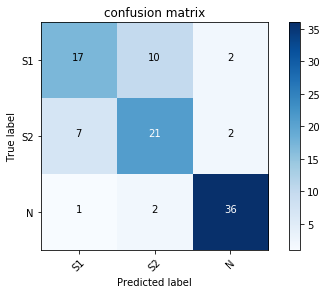

In [1455]:
cnf_matrix = confusion_matrix(y_test_argmax, y_test_prd_result)
plot_confusion_matrix(cnf_matrix, classes=classes, normalize=False,
                      title='confusion matrix')

In [1457]:
precision_recall_fscore_support(y_test_argmax, y_test_prd_result, average=None)

(array([ 0.68      ,  0.63636364,  0.9       ]),
 array([ 0.5862069 ,  0.7       ,  0.92307692]),
 array([ 0.62962963,  0.66666667,  0.91139241]),
 array([29, 30, 39]))

#### For file : normal__201102081321: 
S1 starts at segment 13, ends at segment 25: HS1 Starts: 0.15sec ends at 0.29 sec
In another example for the same file:
The Gap between two Heart Sounds  starts at segment 47, ends at segment 59: HS1 Starts: 0.545sec ends at 0.684 sec 

similarly S2 starts at segment 192, ends at segment 204: HS1 Starts: 2.229 sec ends at 2.368 sec

(note: .011 sec of audio signal corresponds to 1 segment)

### References:
MNIST example using Conv.net: https://www.tensorflow.org/get_started/mnist/pros

convolutional neural network to distinguish the sound of foosball goals from other noises using TensorFlow:
https://humblesoftwaredev.wordpress.com/2016/05/02/an-audio-dataset-and-ipython-notebook-for-training-a-convolutional-neural-network-to-distinguish-the-sound-of-foosball-goals-from-other-noises-using-tensorflow/
